In [1]:
import torch  
from torch.utils.data import Dataset, DataLoader  
import torchvision.transforms as transforms  
from torchvision.datasets import ImageFolder  
from PIL import Image  
import pathlib  
import cupy as cp 
from torchvision.datasets import ImageFolder
from torchvision import datasets
import torch  
import torch.nn as nn  
import torch.optim as optim  
from PIL import Image

In [2]:
# Verificar la disponibilidad de la GPU  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
print("GPU disponible:", torch.cuda.is_available())
print("Nombre de la GPU:", torch.cuda.get_device_name() if torch.cuda.is_available() else "N/A")


GPU disponible: True
Nombre de la GPU: NVIDIA GeForce RTX 4060


In [6]:
# Definir directorios
directorio_dataset = '../Datasets/CIFAR-10'
imagenes_train = '../Datasets/CIFAR-10/train'
imagenes_test = '../Datasets/CIFAR-10/test'

directorio_dataset = pathlib.Path(directorio_dataset)
imagenes_train = pathlib.Path(imagenes_train)
imagenes_test = pathlib.Path(imagenes_test)

# Images dimensions
img_height = 32
img_width = 32
channels = 3
batch_size = 32

# Transformaciones para preprocesamiento de datos
transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),  # Ajustar tamaño a 32x32
    transforms.ToTensor(),  # Convertir a tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizar
])

class CustomImageDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = pathlib.Path(directory)
        self.transform = transform
        self.images = list(self.directory.glob('*.png'))

    def __len__(self):  
        return len(self.images)  

    def __getitem__(self, idx):  
        img_path = self.images[idx]  
        image = Image.open(img_path).convert('RGB')  
        if self.transform:  
            image = self.transform(image)  
        return image

# Crear datasets personalizados
dataset_completo = datasets.ImageFolder(root=str(directorio_dataset), transform=transform)
dataset_train = datasets.ImageFolder(root=str(imagenes_train), transform=transform)
dataset_test = datasets.ImageFolder(root=str(imagenes_test), transform=transform)

# Calcular totales
total_dataset = len(list(directorio_dataset.glob('*/*/*.png')))
total_train = len(list(imagenes_train.glob('*/*.png')))
total_test = len(list(imagenes_test.glob('*/*.png')))

# Crear el DataLoader para iterar sobre los datos en lotes
dataloader_completo = DataLoader(dataset_completo, batch_size=batch_size, shuffle=False, num_workers=0)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

print(f"Total imágenes dataset: {total_dataset}")  
print(f"Total imágenes train: {total_train}")  
print(f"Total imágenes test: {total_test}")

# Get the train class names
class_names_train = dataset_train.classes
num_classes_train = len(class_names_train)

print(f"\nNúmero de clases en train: {num_classes_train}")
print(f"Los nombres de las clases train son: {class_names_train}")

# Get the test class names
class_names_test = dataset_test.classes
num_classes_test = len(class_names_test)

print(f"\nNúmero de clases en test: {num_classes_test}")
print(f"Los nombres de las clases test son: {class_names_test}")


Total imágenes dataset: 60000
Total imágenes train: 50000
Total imágenes test: 10000

Número de clases en train: 10
Los nombres de las clases train son: ['airplane_train', 'automobile_train', 'bird_train', 'cat_train', 'deer_train', 'dog_train', 'frog_train', 'horse_train', 'ship_train', 'truck_train']

Número de clases en test: 10
Los nombres de las clases test son: ['airplane_test', 'automobile_test', 'bird_test', 'cat_test', 'deer_test', 'dog_test', 'frog_test', 'horse_test', 'ship_test', 'truck_test']


In [7]:
def get_transform(channels):   # Aqui define los canales de entrada que se aplicaran al modelo
    if channels == 3:
        # Definir transformaciones para el conjunto de datos en escala a color
        transform = transforms.Compose([
            transforms.Resize((img_height, img_width)),  # Ajustar tamaño
            transforms.ToTensor(),  # Convertir a tensor
            transforms.Normalize((0.5,), (0.5,))  # Normalizar
        ])
    elif channels == 1:
        # Definir transformaciones para el conjunto de datos en escala de grises
        transform = transforms.Compose([
            transforms.Grayscale(),  # Convertir a escala de grises
            transforms.Resize((img_height, img_width)),  # Ajustar tamaño
            transforms.ToTensor(),  # Convertir a tensor
            transforms.Normalize((0.5,), (0.5,))  # Normalizar
        ])
    else: 
        print("El valor elegido no está dentro del rango, por favor elija nuevamente")
        return None  # Devolver None en caso de elección inválida
    return transform

In [11]:
# Obtener las transformaciones según la elección  
transform = get_transform(channels)  

# Crear el dataset completo con las transformaciones aplicadas  
if transform is not None:  
    train_dataset = datasets.ImageFolder(root=imagenes_train, transform=transform)  # En train dataset se toma el dataset completo para entrenarlo
else:  
    print("No se puede crear el dataset debido a una elección inválida.")  


# Crear el DataLoader para iterar sobre el dataset completo  
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0) 


In [12]:
# Cargar el conjunto de datos de prueba  
test_dataset = datasets.ImageFolder(root=str(imagenes_test), transform=transform)  
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  

In [15]:

# Definir el modelo de clasificación multiclase  
class MulticlassCNN(nn.Module):  
    def __init__(self, num_classes_train):  
        super(MulticlassCNN, self).__init__()  
        self.conv1 = nn.Conv2d(channels, 16, kernel_size=3, stride=1, padding=1)  
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)  
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  
        self.fc1 = nn.Linear(32 * 8 * 8, 128)  
        self.fc2 = nn.Linear(128, num_classes_train)  
        self.relu = nn.ReLU()  

    def forward(self, x):  
        x = self.pool(self.relu(self.conv1(x)))  
        x = self.pool(self.relu(self.conv2(x)))  
        x = x.view(-1, 32 * 8 * 8)  
        x = self.relu(self.fc1(x))  
        x = self.fc2(x)  
        return x  

# Instanciar el modelo  
model = MulticlassCNN(num_classes_train=num_classes_train).to(device)  


# Definir la función de pérdida y el optimizador  
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001)  


# Ejemplo de bucle de entrenamiento  
num_epochs = 10  
for epoch in range(num_epochs):  
    model.train()  # Asegurarse de que el modelo está en modo de entrenamiento  

    running_loss = 0.0  
    correct = 0  
    total = 0  

    for images, labels in train_loader:  
        images, labels = images.to(device), labels.to(device)  

        # Adelante  
        outputs = model(images)  
        loss = criterion(outputs, labels)  

        # Atrás y optimización  
        optimizer.zero_grad()  
        loss.backward()  
        optimizer.step()  

        # Actualizar estadísticas  
        running_loss += loss.item()  

        # Calcular precisión  
        _, predicted = torch.max(outputs, 1)  
        total += labels.size(0)  
        correct += (predicted == labels).sum().item()  

    epoch_loss = running_loss / len(train_loader)  
    accuracy = 100 * correct / total  

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")  

print("Entrenamiento completado")

Epoch [1/10], Loss: 1.3883, Accuracy: 49.92%
Epoch [2/10], Loss: 1.0405, Accuracy: 63.00%
Epoch [3/10], Loss: 0.8935, Accuracy: 68.60%
Epoch [4/10], Loss: 0.7868, Accuracy: 72.17%
Epoch [5/10], Loss: 0.6979, Accuracy: 75.40%
Epoch [6/10], Loss: 0.6252, Accuracy: 77.77%
Epoch [7/10], Loss: 0.5530, Accuracy: 80.26%
Epoch [8/10], Loss: 0.4865, Accuracy: 82.74%
Epoch [9/10], Loss: 0.4294, Accuracy: 84.67%
Epoch [10/10], Loss: 0.3736, Accuracy: 86.62%
Entrenamiento completado


In [16]:
# Obtener predicciones

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support  
import numpy as np

# Evaluación del modelo  
model.eval()  

all_labels = []  
all_predictions = []  

with torch.no_grad():  
    for images, labels in test_loader:  
        images, labels = images.to(device), labels.to(device)  
        outputs = model(images)  
        
        _, predicted = torch.max(outputs, 1)  
        all_labels.extend(labels.cpu().numpy())  
        all_predictions.extend(predicted.cpu().numpy())  

# Convertir listas a arrays para usar en scikit-learn  
all_labels = np.array(all_labels)  
all_predictions = np.array(all_predictions)  

In [17]:
# Presicion, recall y F1 score

from sklearn.metrics import precision_recall_fscore_support  

# Calcular precisión, recall, F1-score  
precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, all_predictions, average=None)  

# Mostrar resultados  
for class_name, prec, rec, f1 in zip(class_names_test, precision, recall, f1_score):  
    print(f"Class: {class_name} - Precision: {prec:.2f}, Recall: {rec:.2f}, F1 Score: {f1:.2f}")  

# Para obtener los promedios:  
average_precision, average_recall, average_f1_score, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')  
print(f"Weighted Average Precision: {average_precision:.2f}")  
print(f"Weighted Average Recall: {average_recall:.2f}")  
print(f"Weighted Average F1 Score: {average_f1_score:.2f}") 

Class: airplane_test - Precision: 0.74, Recall: 0.72, F1 Score: 0.73
Class: automobile_test - Precision: 0.80, Recall: 0.81, F1 Score: 0.80
Class: bird_test - Precision: 0.59, Recall: 0.58, F1 Score: 0.59
Class: cat_test - Precision: 0.52, Recall: 0.45, F1 Score: 0.48
Class: deer_test - Precision: 0.59, Recall: 0.69, F1 Score: 0.63
Class: dog_test - Precision: 0.65, Recall: 0.53, F1 Score: 0.58
Class: frog_test - Precision: 0.75, Recall: 0.76, F1 Score: 0.76
Class: horse_test - Precision: 0.71, Recall: 0.76, F1 Score: 0.73
Class: ship_test - Precision: 0.80, Recall: 0.84, F1 Score: 0.82
Class: truck_test - Precision: 0.73, Recall: 0.77, F1 Score: 0.75
Weighted Average Precision: 0.69
Weighted Average Recall: 0.69
Weighted Average F1 Score: 0.69


In [18]:
for i, (image, label) in enumerate(test_loader):  
    image, label = image.to(device), label.to(device)  
    output = model(image)  
    _, predicted = torch.max(output, 1)  
    # Imprime algunas predicciones y etiquetas reales  
    if i < 5:  # Limita a las primeras 5 iteraciones   
        print(f"Etiqueta Real: {label.cpu().numpy()}, Predicción: {predicted.cpu().numpy()}") 

Etiqueta Real: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], Predicción: [8 0 0 0 8 0 0 0 0 0 0 8 0 8 8 0 8 0 0 0 0 0 0 8 0 0 0 0 0 9 0 2]
Etiqueta Real: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], Predicción: [1 0 0 0 0 0 0 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Etiqueta Real: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], Predicción: [0 0 9 0 0 0 0 0 0 0 0 0 2 8 0 0 0 0 0 0 0 0 0 0 0 8 0 0 0 9 0 9]
Etiqueta Real: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], Predicción: [0 0 0 0 0 0 0 8 0 8 0 0 8 0 0 0 0 2 0 8 0 0 8 8 0 0 0 8 0 0 0 0]
Etiqueta Real: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], Predicción: [4 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 2 8 0 3 0 0 0 0 8 5 0 0]


Matriz de Confusión:
[[725  14  62  15  22   4  12  11  94  41]
 [ 18 812  15   8   9   3   9   2  19 105]
 [ 72   8 580  47 110  51  65  44  15   8]
 [ 35  21  79 449  95 137  77  53  18  36]
 [ 23   7  61  55 685  21  46  81  15   6]
 [ 15   7  64 187  76 529  24  68   9  21]
 [  4   7  55  40  76  22 763  15   6  12]
 [ 17   3  35  46  71  39   6 756   2  25]
 [ 38  39  18  11  12   2   7   7 836  30]
 [ 32 100   9  12   8   4   9  23  29 774]]


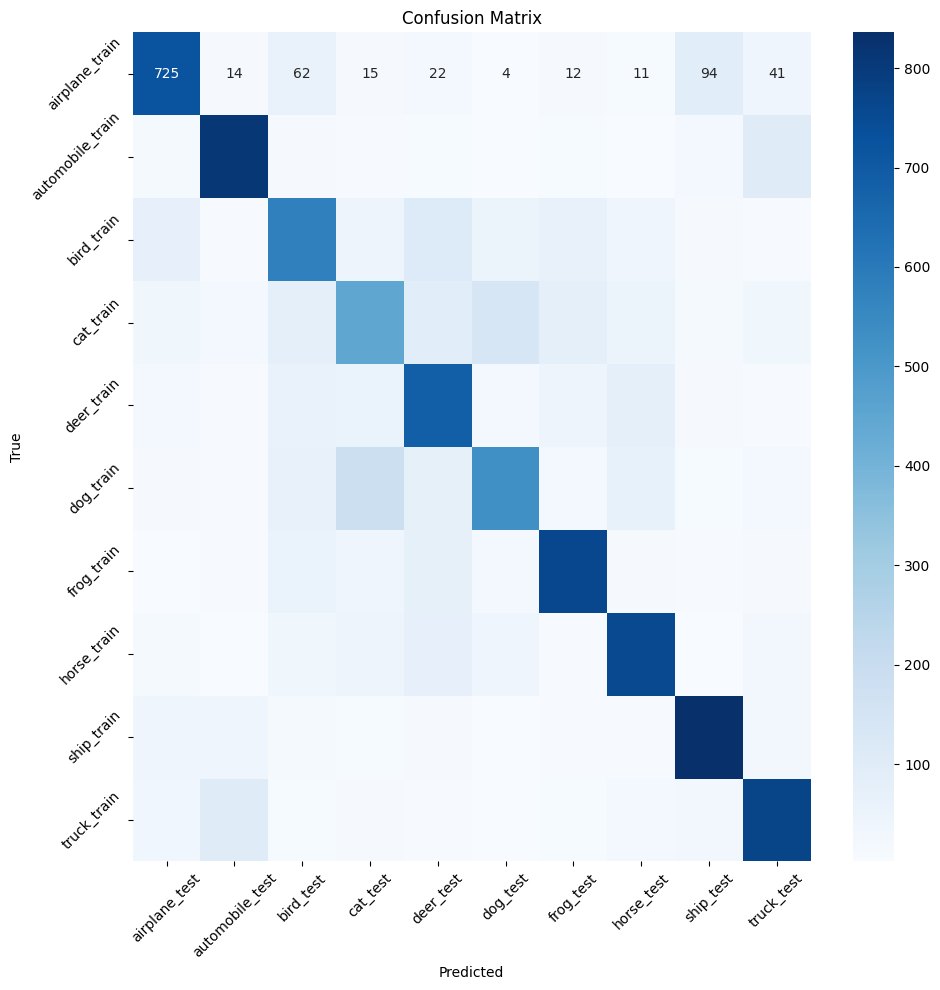

In [24]:
import matplotlib.pyplot as plt  
import seaborn as sns  
from sklearn.metrics import confusion_matrix  

# Calcular la matriz de confusión  
cm = confusion_matrix(all_labels, all_predictions)  

# Verificar la matriz de confusión  
print("Matriz de Confusión:")  
print(cm)  

# Visualizar la matriz de confusión  
plt.figure(figsize=(10,10))  
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names_test, yticklabels=class_names_train)  
plt.xlabel('Predicted')  
plt.ylabel('True')  
plt.title('Confusion Matrix') 
plt.xticks(rotation=45) 
plt.yticks(rotation=45) 
plt.tight_layout()  # Asegura que todo el contenido se ajuste dentro de la figura  
plt.show()